# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

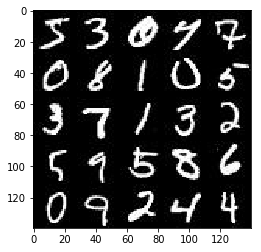

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

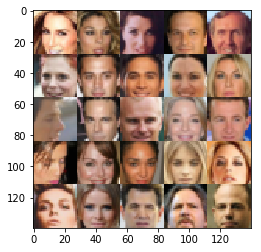

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_data = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_data')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_data, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\anaconda3\\envs\\udacity_learning_2_35\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\anaconda3\\envs\\udacity_learning_2_35\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\anaconda3\\envs\\udacity_learning_2_35\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "c:\\anaconda3\\envs\\udacity_learning_2_35\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\anaconda3\\envs\\udacity_learning_2_35\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [110]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x256

        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [111]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits) / 2
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [112]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [113]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
     # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [114]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [115]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    steps = 0
    
    input_data, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_data, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_data: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_data: batch_images, input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_data: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 64, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 64, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0234... Generator Loss: 4.9699
Epoch 1/2... Discriminator Loss: 0.2287... Generator Loss: 5.5464
Epoch 1/2... Discriminator Loss: 2.1291... Generator Loss: 0.3508
Epoch 1/2... Discriminator Loss: 1.9486... Generator Loss: 0.2672
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.8441... Generator Loss: 0.2478
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 1.4888


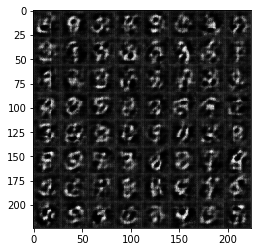

Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 2.3202... Generator Loss: 0.1270
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 1.6901... Generator Loss: 0.2647
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.5349... Generator Loss: 0.3291
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.8728


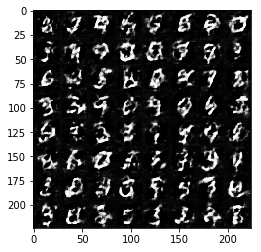

Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 1.5249
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 0.4676
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.4981
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 1.5581
Epoch 1/2... Discriminator Loss: 1.6396... Generator Loss: 0.3084
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.8664


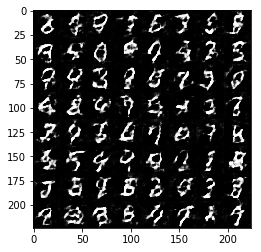

Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.7720
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.7030
Epoch 1/2... Discriminator Loss: 1.9836... Generator Loss: 1.8239
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 1.6882
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 1.2450
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 1.7600... Generator Loss: 0.2490
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.4568


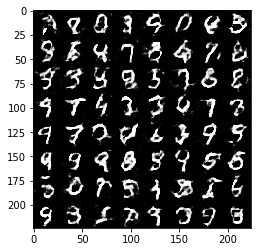

Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.3667
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 0.6323
Epoch 1/2... Discriminator Loss: 1.5015... Generator Loss: 1.7191
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 1.6631
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.3358
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.8144... Generator Loss: 1.9675
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.6555


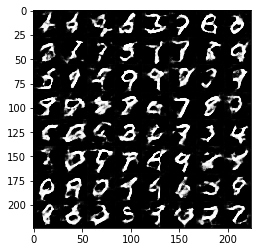

Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.5233... Generator Loss: 0.3903
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.9540
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 1.5596
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 1.0867


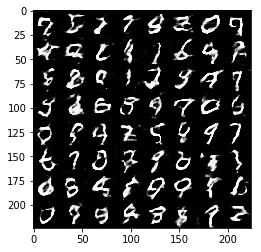

Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.4044
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 1.5840... Generator Loss: 0.3775
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.4031
Epoch 2/2... Discriminator Loss: 1.6548... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 1.5482... Generator Loss: 0.3539
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 0.3605


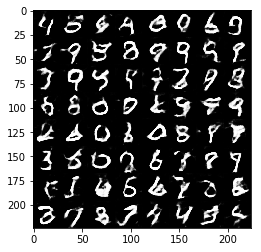

Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 1.2653
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 1.4874
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.1717... Generator Loss: 0.5938
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.5962
Epoch 2/2... Discriminator Loss: 2.1408... Generator Loss: 0.2011


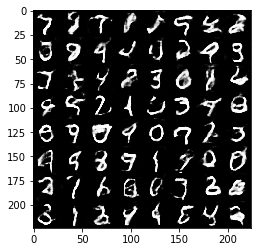

Epoch 2/2... Discriminator Loss: 5.0795... Generator Loss: 0.0192
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.4957
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 1.2191
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 1.6452


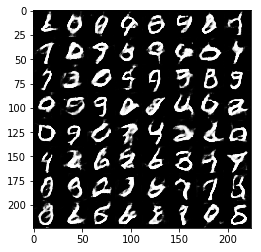

Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.5738
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.5280


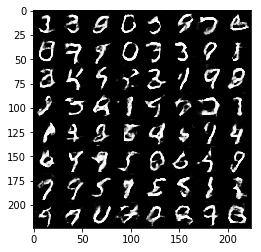

In [116]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2726... Generator Loss: 3.8644
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 17.9332
Epoch 1/1... Discriminator Loss: 2.2971... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 2.0537... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.3133
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.3868


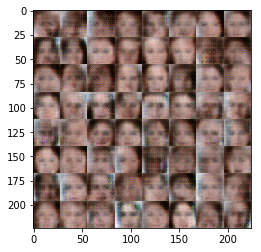

Epoch 1/1... Discriminator Loss: 2.0728... Generator Loss: 0.1727
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 6.7405
Epoch 1/1... Discriminator Loss: 0.2289... Generator Loss: 3.1140
Epoch 1/1... Discriminator Loss: 2.1811... Generator Loss: 2.6576
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 4.2429
Epoch 1/1... Discriminator Loss: 2.7485... Generator Loss: 0.0961
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 3.3954
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 3.9082
Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 3.3444


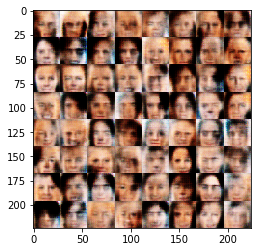

Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 3.1135
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 2.7719
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 3.0193
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 3.8698
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 4.3772
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.5604


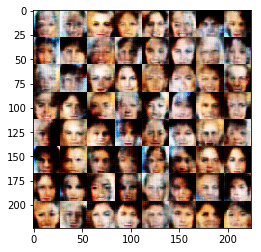

Epoch 1/1... Discriminator Loss: 1.8603... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.6549
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 3.0933
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.7142


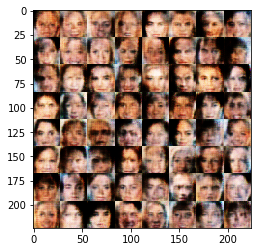

Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 4.7639
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 3.6457
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 1.9085
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 2.0536
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.0224


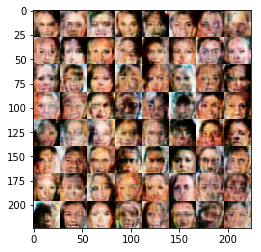

Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.5797
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.3214
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 4.2663
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.0847
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.7037


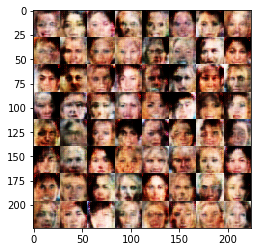

Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.1356
Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 2.8956
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 4.0133
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 2.3934
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 2.1971... Generator Loss: 0.2104
Epoch 1/1... Discriminator Loss: 1.8598... Generator Loss: 3.5948
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.6394
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.5437


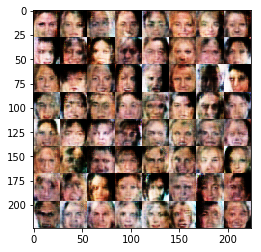

Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.3863
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.2812
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 3.6518
Epoch 1/1... Discriminator Loss: 3.1169... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 2.4545


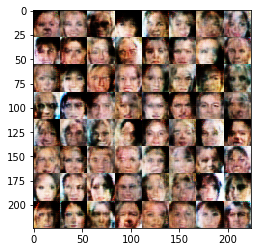

Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 2.4755
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 1.7397
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 2.8604
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 2.6450
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 2.8827
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.2856... Generator Loss: 4.7122
Epoch 1/1... Discriminator Loss: 2.0125... Generator Loss: 0.2250
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 2.9330


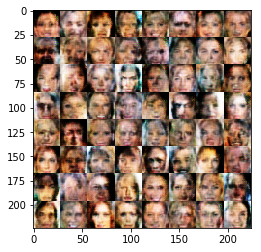

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.7841
Epoch 1/1... Discriminator Loss: 1.8463... Generator Loss: 1.8691
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.5960
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 3.2160
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 2.1241
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.4945


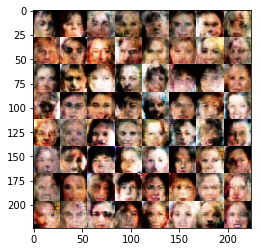

Epoch 1/1... Discriminator Loss: 2.0762... Generator Loss: 2.4977
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.9463
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 1.9295
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 1.9171
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.8850
Epoch 1/1... Discriminator Loss: 2.0613... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.5351


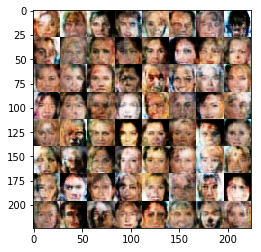

Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 2.8970
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 2.9663
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.8237
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.5743
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 4.1866
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 5.6370
Epoch 1/1... Discriminator Loss: 8.0131... Generator Loss: 2.5327
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6119


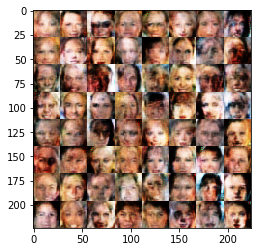

Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 2.0290... Generator Loss: 0.1959
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.7182
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.6093
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 2.1551
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.3004
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 2.9340


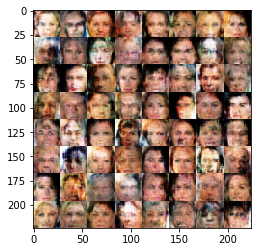

Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 2.3995
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 2.6713
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 3.4412
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.4024
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 2.7970
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 2.1720


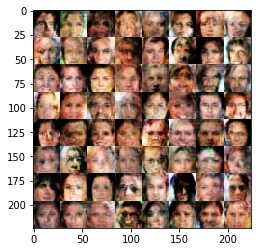

Epoch 1/1... Discriminator Loss: 0.2933... Generator Loss: 3.3561
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 3.7696
Epoch 1/1... Discriminator Loss: 1.9483... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.9476
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.7394
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 2.0830


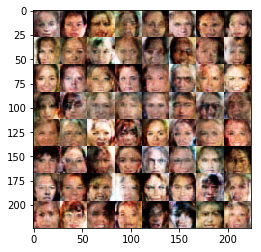

Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.3645
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.1548
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 2.5138
Epoch 1/1... Discriminator Loss: 2.5370... Generator Loss: 2.5549
Epoch 1/1... Discriminator Loss: 1.7984... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.9563
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.7758


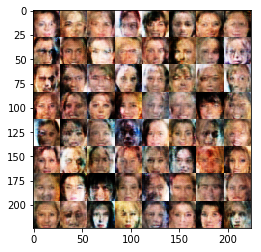

In [117]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.